# Halioglobus gene analysis


In [2]:
import pandas as pd
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator
import anndata
import scanpy as sc
import matplotlib.patches as mpatches

In [3]:
gfam_dir = '/drive4/xiangpeng/Project/bacteria/ocean_beach/split/scFASTQ/Halioglobus/humann/gfam/'
gfam_file = gfam_dir+ 'gfam_all_with_names.tsv'
gfam_df = pd.read_csv(gfam_file, index_col =0, sep = '\t')
out_dir = '/drive4/xiangpeng/Project/bacteria/ocean_beach/split/scFASTQ/Halioglobus/analysis/'

In [4]:
gfam_df = gfam_df.drop('UNMAPPED')

In [5]:

gfam_df['gene_fam'] =[x.split('|')[0] for x in gfam_df.index]
gfam_df = gfam_df.drop_duplicates(subset=['gene_fam']).drop(columns='gene_fam')

In [43]:
gfam_df.T.to_csv(gfam_dir + 'gfam_all_with_names_dedup.tsv')

<AxesSubplot:ylabel='Frequency'>

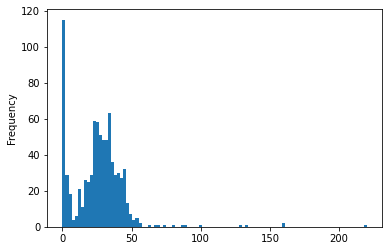

In [23]:
gfam_df.astype(bool).sum().plot.hist(bins=100)

<AxesSubplot:>

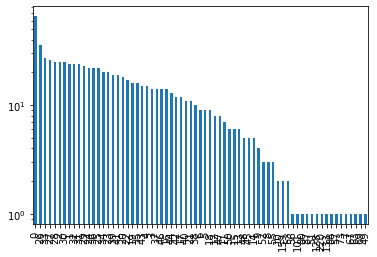

In [24]:
gfam_df.astype(bool).sum().value_counts().plot.bar(logy=True)

<AxesSubplot:ylabel='Frequency'>

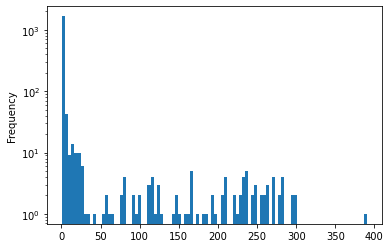

In [25]:
gfam_df.astype(bool).sum(axis=1).plot.hist(bins=100, logy=True)

(187, 665)


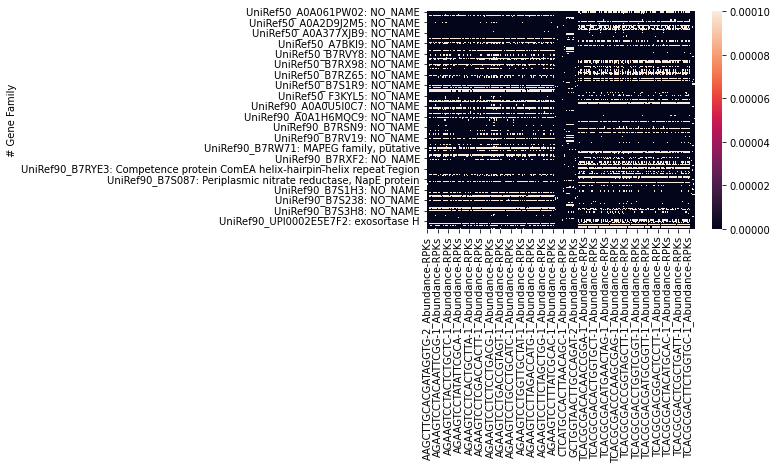

In [26]:
min_cell_cnt = 5
min_gene_cnt = 5
sns.heatmap(gfam_df.loc[(gfam_df.astype(bool).sum(axis=1) >= min_cell_cnt),(gfam_df.astype(bool).sum(axis=0) >= min_gene_cnt)], vmax =0.0001)
print(gfam_df.loc[(gfam_df.astype(bool).sum(axis=1) >= min_cell_cnt),(gfam_df.astype(bool).sum(axis=0) >= min_gene_cnt)].shape)

/usr/local/lib/python3.9/dist-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


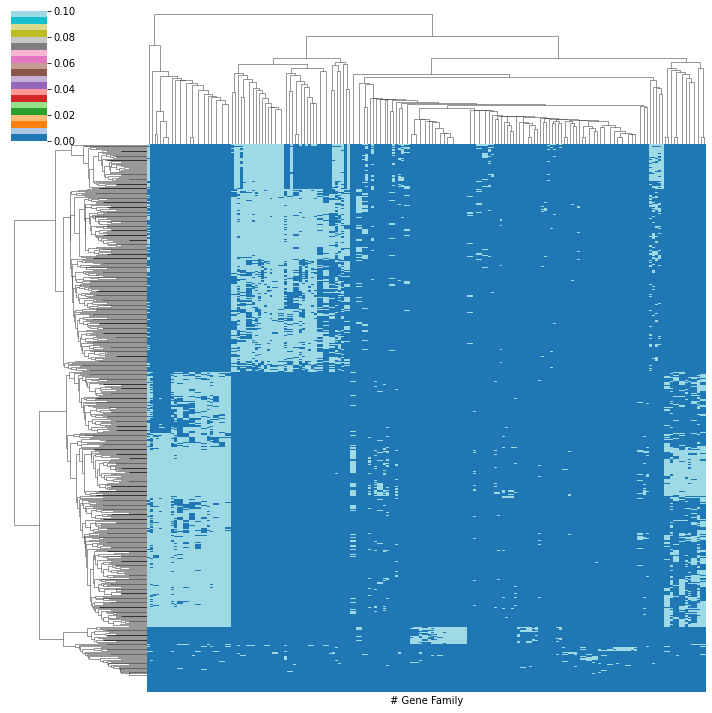

In [27]:
filtered_gfam = gfam_df.astype(bool).loc[(gfam_df.astype(bool).sum(axis=1) >= min_cell_cnt),(gfam_df.astype(bool).sum(axis=0) >= min_gene_cnt)].astype(int)
g=sns.clustermap(filtered_gfam.T, 
               figsize=(10,10),
                 yticklabels=False,
                 xticklabels=False,
                cmap='tab20',
                vmax=0.1)



In [28]:
reordered_gfam = filtered_gfam.iloc[g.dendrogram_col.reordered_ind, g.dendrogram_row.reordered_ind]

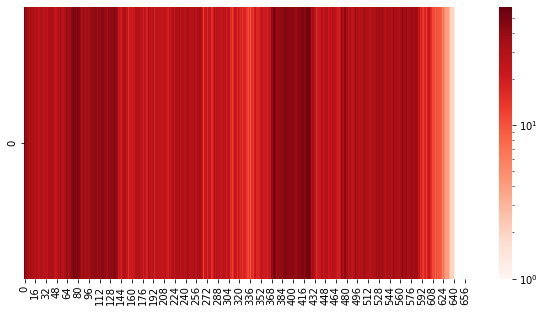

In [29]:
## plot read count side bar
plt.figure(figsize=(10,5))
ax = sns.heatmap([reordered_gfam.sum().tolist()], cmap='Reds', norm=LogNorm())
 

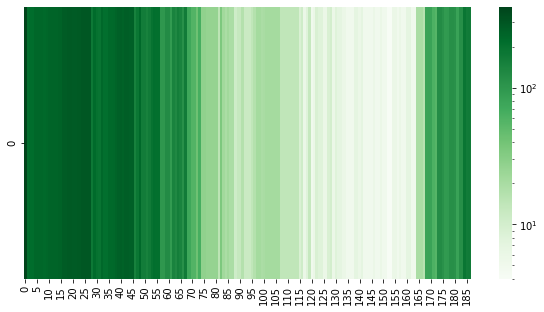

In [30]:
## plot gene's apperence count side bar
plt.figure(figsize=(10,5))
ax = sns.heatmap([reordered_gfam.sum(axis=1).tolist()], cmap='Greens',norm=LogNorm())

In [31]:
adata_t = anndata.AnnData(reordered_gfam.T)

/tmp/ipykernel_17125/1321460739.py:1: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_t = anndata.AnnData(reordered_gfam.T)


In [32]:
reordered_gfam.to_csv(gfam_dir+'filtered_gfam_v2.csv')

In [33]:
sc.pp.neighbors(adata_t, use_rep='X')
sc.tl.leiden(adata_t, resolution=0.2)

In [34]:
sc.tl.umap(adata_t)

In [35]:
adata_t

AnnData object with n_obs × n_vars = 665 × 187
    obs: 'leiden'
    uns: 'neighbors', 'leiden', 'umap'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

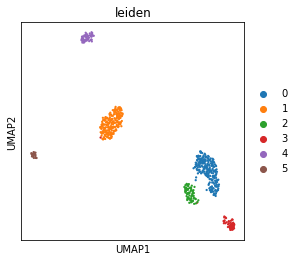

In [40]:
with plt.rc_context({"figure.figsize": (4, 4), }):
    sc.pl.umap(adata_t, 
               color='leiden', 
               size =20, 
               frameon= True,
               save = 'Halioglobus_subclustering_by_genes_umap_v2.pdf'
              )

plt.show()

In [41]:
out_dir


'/drive4/xiangpeng/Project/bacteria/ocean_beach/split/scFASTQ/Halioglobus/analysis/'

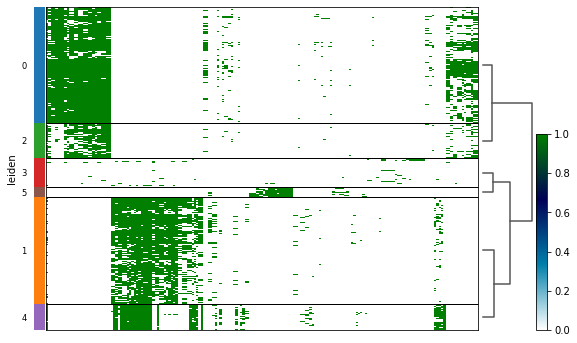

In [42]:

ax = sc.pl.heatmap(adata_t, 
                       adata_t.var_names, 
                       groupby='leiden', 
                       dendrogram=True,
                   cmap='ocean_r',
                       save ='Halioglobus_subclustering_by_genes_heatmap_v2.pdf')
#plt.savefig(out_dir+'Halioglobus_subclustering_by_genes_heatmap.pdf', bbox_inches='tight') 
plt.show()

## SNP analysis

### Barcode group SNP calling 
    3.1. spade assembly
    
    ```
    /drive1/xiangpeng/apps/SPAdes-3.15.3-Linux/bin/spades.py   --careful -t 32  -1 /drive4/xiangpeng/Project/bacteria/ocean_beach/split/scFASTQ/grouped_fq/Halioglobus/HalioglobusR1_combined.fastq -2 /drive4/xiangpeng/Project/bacteria/ocean_beach/split/scFASTQ/grouped_fq/Halioglobus/HalioglobusR2_combined.fastq -o /drive4/xiangpeng/Project/bacteria/ocean_beach/split/scFASTQ/grouped_fq/Halioglobus/Halioglobus_assembly
    ```
    3.2. build bowtie2 reference
    ```
    bowtie2-build --threads 32 /drive4/xiangpeng/Project/bacteria/ocean_beach/split/scFASTQ/grouped_fq/Halioglobus/Halioglobus_assembly/contigs.fasta /drive4/xiangpeng/Project/bacteria/ocean_beach/split/scFASTQ/grouped_fq/Halioglobus/Halioglobus_assembly/bt2
    ```
    3.3. align each barcode group to the contig reference
    
    3.4. snp calling
    

In [45]:
halio_dir = '/drive4/xiangpeng/Project/bacteria/ocean_beach/split/scFASTQ/top5_subcluster/halioglobus/'
halio_bar_file =halio_dir + 'halioglobus_subcluster.csv'
bar_cluster = pd.read_csv(halio_bar_file,)

bars = bar_cluster['Unnamed: 0'].tolist()


In [48]:
fq_dir = '/drive4/xiangpeng/Project/bacteria/ocean_beach/split/scFASTQ/fq/'
Halioglobus_dir = '/drive4/xiangpeng/Project/bacteria/ocean_beach/split/scFASTQ/Halioglobus/'
ref = '/drive4/xiangpeng/Project/bacteria/ocean_beach/split/scFASTQ/grouped_fq/Halioglobus/Halioglobus_assembly/bt2'
sam_dir = Halioglobus_dir + 'sam/'

In [ ]:
n =1
for bar in bars[:]:
    #print('processing barcode # {} of {}, {}'.format(n, len(bars), bar))
    r1 = fq_dir + bar + '_R1.fastq'
    r2 = fq_dir + bar + '_R2.fastq'
    bam = sam_dir + bar + '.bam'
    
    ## bowtie2 alignment command
    bt2_cmd = 'bowtie2 -p 32 -x {} -1 {} -2 {} | samtools view -q 2 -@ 32 -Sb -o {}'.format(ref, r1, r2, bam)
    #print(bt2_cmd)
    #os.system(bt2_cmd)
    
    ## mpileup generate VCF 
    bcf = sam_dir + bar + '.bcf'
    mpileup_cmd = 'samtools mpileup -g -f {} -o {} '.format( sort_bam, bam)
    #print(sort_cmd)
    #os.system(sort_cmd)
    
    ## index Bam 
    sort_bam = sam_dir + bar + '_sorted.bam'
    sort_cmd = 'samtools sort -o {} {}'.format( sort_bam, bam)
    #print(sort_cmd)
    #os.system(sort_cmd)
        
    rmdup_bam = sam_dir + bar + '_srt_unq.bam'
    rmdup_cmd = 'samtools rmdup -S {} {}'.format(sort_bam, rmdup_bam)
    #print(rmdup_cmd)
    #os.system(sort_cmd)
    n+=1

### SNP calling
for f in *sorted.bam;  do samtools rmdup -S ${f} ${f}_unq.bam; done;

bcftools view -bvcg sorted.bcf > sorted_var.bcf
bcftools index -o sorted_idx.bcf  sorted.bcf

bcftools call --skip-variants indels --multiallelic-caller --variants-only  -O v -o snp_call.vcf  sorted_idx.bcf

bcftools call --ploidy 1 -v -m sorted.bcf > calls.vcf

bcftools view -v snps -m2 -M2 --min-ac 1:minor calls.vcf > snp.vcf

 bcftools mpileup  -f /drive4/xiangpeng/Project/bacteria/ocean_beach/split/scFASTQ/grouped_fq/Halioglobus/Halioglobus_assembly/contigs.fasta *_sorted.bam -o sorted.bcf --threads 32
 
bcftools call --ploidy 1 -v -m sorted.bcf > calls.vcf

bcftools view -v snps -m2 -M2 --min-ac 1:minor calls.vcf > snp.vcf



In [49]:
snp_file = sam_dir +  'snp.vcf'
def get_vcf_names(vcf_path):
    with open(vcf_path, "rt") as ifile:
          for line in ifile:
            if line.startswith("#CHROM"):
                vcf_names = [x for x in line.split('\n')[0].split('\t')]
                break
    ifile.close()
    return vcf_names


names = get_vcf_names(snp_file)
snp = pd.read_csv(snp_file, comment='#', delim_whitespace=True, header=None, names=names)

In [50]:
snp.columns = snp.columns.str.strip('_sorted.bam').tolist()
snp

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,AAGCTTGCACGATAGGTG-2,...,TGTTGTCGAGACCAACAG-2,TTAACGGAGGCGTATAGG-2,TTACACCTTTACGTTACC-1,TTAGATCGGTTAGTCGGA-2,TTCACCTTGACAGCGTAT-2,TTCACTCCTCCGCACTCA-2,TTCCAATTCTTCACCTTG-2,TTCCAGATTGGACACTGG-1,TTGAGACGGACTCTGCTC-1,TTGTATCACGGTGTTCAT-2
0,NODE_1_length_11243_cov_29.584005,741,.,A,C,26.22150,.,DP=10;VDB=0.02;SGB=0.405052;RPBZ=1.41233;BQBZ=...,GT:PL,".:0,0",...,".:0,0",".:0,0",".:0,0",".:0,0",".:0,0",".:0,0",".:0,0",".:0,0",".:0,0",".:0,0"
1,NODE_1_length_11243_cov_29.584005,947,.,T,C,10.42400,.,DP=3;SGB=-0.000309214;FS=0;MQ0F=0;AC=1;AN=2;DP...,GT:PL,".:0,0",...,".:0,0",".:0,0",".:0,0",".:0,0",".:0,0",".:0,0",".:0,0",".:0,0",".:0,0",".:0,0"
2,NODE_1_length_11243_cov_29.584005,1888,.,C,T,62.73930,.,DP=5;VDB=0.0221621;SGB=0.916103;RPBZ=1.22474;F...,GT:PL,".:0,0",...,".:0,0",".:0,0",".:0,0",".:0,0",".:0,0",".:0,0",".:0,0",".:0,0",".:0,0",".:0,0"
3,NODE_1_length_11243_cov_29.584005,2667,.,A,T,10.42800,.,DP=2;SGB=-0.000309214;FS=0;MQ0F=0;AC=1;AN=2;DP...,GT:PL,".:0,0",...,".:0,0",".:0,0",".:0,0",".:0,0",".:0,0",".:0,0",".:0,0",".:0,0",".:0,0",".:0,0"
4,NODE_1_length_11243_cov_29.584005,2675,.,A,G,10.42800,.,DP=2;SGB=-0.000309214;FS=0;MQ0F=0;AC=1;AN=2;DP...,GT:PL,".:0,0",...,".:0,0",".:0,0",".:0,0",".:0,0",".:0,0",".:0,0",".:0,0",".:0,0",".:0,0",".:0,0"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7533,NODE_21849_length_91_cov_297.500000,37,.,T,C,3.34777,.,DP=178;SGB=-0.000309214;MQBZ=1.92902;MQSBZ=-0....,GT:PL,".:0,0",...,".:0,0",".:0,0",".:0,0",".:0,0",".:0,0",".:0,0",".:0,0",".:0,0",".:0,0",".:0,0"
7534,NODE_21849_length_91_cov_297.500000,43,.,C,T,13.74310,.,DP=180;VDB=0.02;SGB=-0.00123762;RPBZ=0.15162;M...,GT:PL,".:0,0",...,".:0,0",".:0,0",".:0,0",".:0,0",".:0,0",".:0,0",".:0,0",".:0,0",".:0,0",".:0,0"
7535,NODE_28722_length_86_cov_608.000000,63,.,A,G,15.00550,.,DP=96;VDB=5.52906e-06;SGB=4.17505;MQBZ=3.93388...,GT:PL,".:0,0",...,".:0,0",".:0,0",".:0,0",".:0,0",".:0,0",".:0,0",".:0,0",".:0,0",".:0,0",".:0,0"
7536,NODE_34267_length_84_cov_0.000000,39,.,A,G,9.13096,.,DP=20;SGB=-0.000309214;MQBZ=2;MQSBZ=1.22474;BQ...,GT:PL,".:0,0",...,".:0,0",".:0,0",".:0,0",".:0,0",".:0,0",".:0,0",".:0,0",".:0,0",".:0,0",".:0,0"


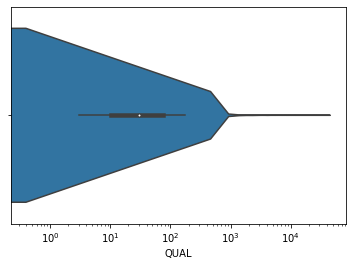

In [184]:

sns.violinplot(data = snp,x = 'QUAL', hue = 'FORMAT')
plt.xscale('log')


In [185]:
# filter snps by quality
print(snp.shape)
snp = snp[snp['QUAL']>=20]
print(snp.shape)

(7538, 818)
(4353, 818)


In [186]:
drop_header = ['#CHROM','POS','ID','REF','ALT','QUAL','FILTER','INFO','FORMAT']
bar_names = [x  for x in snp.columns.tolist() if x not in drop_header]
len(bar_names)

#snp.drop(columns=drop_header)    

809

In [578]:
snp_gt = pd.DataFrame(columns=snp.columns )
snp_gt[drop_header] = snp[drop_header]

for bar in bar_names:
    snp_gt[bar]=snp[bar].str.split(':').str[0].replace('.',np.nan)
    

In [579]:
snp_gt[bar_names]=snp_gt[bar_names].astype(float)

In [580]:
for bar in bar_names:
    snp_gt.loc[snp_gt[bar]==1, bar]= -1
    snp_gt.loc[snp_gt[bar]==0, bar]= 1

In [581]:
snp_gt = snp_gt.fillna(0)
snp_gt['TGTTGTCGAGACCAACAG-2'].value_counts()

 0.0    4328
 1.0      15
-1.0      10
Name: TGTTGTCGAGACCAACAG-2, dtype: int64

In [582]:
snp_alt_cnt = pd.DataFrame(columns=['ref_cnt','alt_cnt','no_detect', 'mut_type'])
for idx in snp.index.tolist():
    snp_dict=snp_gt.loc[idx, bar_names].value_counts().to_dict()
    ref_cnt= snp_dict[1]
    alt_cnt= snp_dict[-1]
    no_detect = snp_dict[0]
    mut_type = snp_gt.loc[idx, 'REF']+'>'+snp_gt.loc[idx, 'ALT']
    new_line = [max([ref_cnt,alt_cnt]), min([ref_cnt,alt_cnt]),no_detect, mut_type]
    new_idx = snp_gt.loc[idx, '#CHROM']
    snp_alt_cnt.loc[new_idx]=new_line
    

In [583]:
snp_alt_cnt['total_cnt']=snp_alt_cnt['ref_cnt']+snp_alt_cnt['alt_cnt']
snp_alt_cnt['alt_ratio']=snp_alt_cnt['alt_cnt']/snp_alt_cnt['ref_cnt']

<AxesSubplot:ylabel='Frequency'>

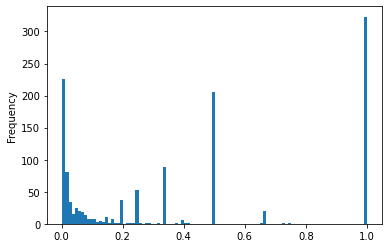

In [584]:
snp_alt_cnt['alt_ratio'].plot.hist(bins=100)


<AxesSubplot:ylabel='Frequency'>

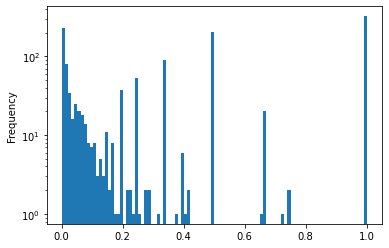

In [585]:
snp_alt_cnt['alt_ratio'].plot.hist(bins= 100, logy=True)

In [586]:
filtered = snp_alt_cnt[(snp_alt_cnt['total_cnt']>200)&(snp_alt_cnt['alt_cnt']>5)].index.tolist()
print(len(filtered))

32


<AxesSubplot:>

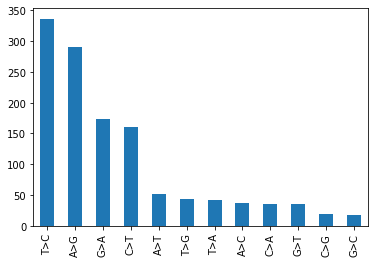

In [587]:
snp_alt_cnt['mut_type'].value_counts().plot.bar()
#plt.yscale('log')
#plt.ylim(1, 1000)

In [588]:
snp_gt_filtered = snp_gt[snp_gt['#CHROM'].isin(filtered)][bar_names]
snp_gt_filtered

,AAGCTTGCACGATAGGTG-2,AAGCTTGCACTCCAGCGT-2,AAGCTTGCATCAAGCGTA-2,AAGGAAGTCAGGTGTACA-1,AAGGTCTGATGTCCATAG-2,AAGGTGCTGCAGTATGAT-2,AATGCAGCGAGGAAGGTG-1,AATGTGCGTCTTCACTGT-2,AATTGGTGAGTCTACCAA-1,ACACCGCCATCGTCCGAT-1,...,TGTTGTCGAGACCAACAG-2,TTAACGGAGGCGTATAGG-2,TTACACCTTTACGTTACC-1,TTAGATCGGTTAGTCGGA-2,TTCACCTTGACAGCGTAT-2,TTCACTCCTCCGCACTCA-2,TTCCAATTCTTCACCTTG-2,TTCCAGATTGGACACTGG-1,TTGAGACGGACTCTGCTC-1,TTGTATCACGGTGTTCAT-2
689,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
697,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
699,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7510,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7511,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7513,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7514,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [589]:
snp_gt_filtered = snp_gt_filtered.loc[:,snp_gt_filtered.astype(bool).sum(axis=0)>50]

In [590]:
snp_gt_filtered.shape

(182, 514)

<AxesSubplot:>

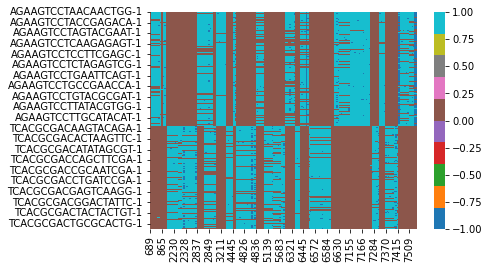

In [591]:
sns.heatmap(snp_gt_filtered.T, cmap= 'tab10')

In [592]:
snp_gt_filtered.columns.name = 'barcodes'
snp_gt_filtered.index.name='snps'

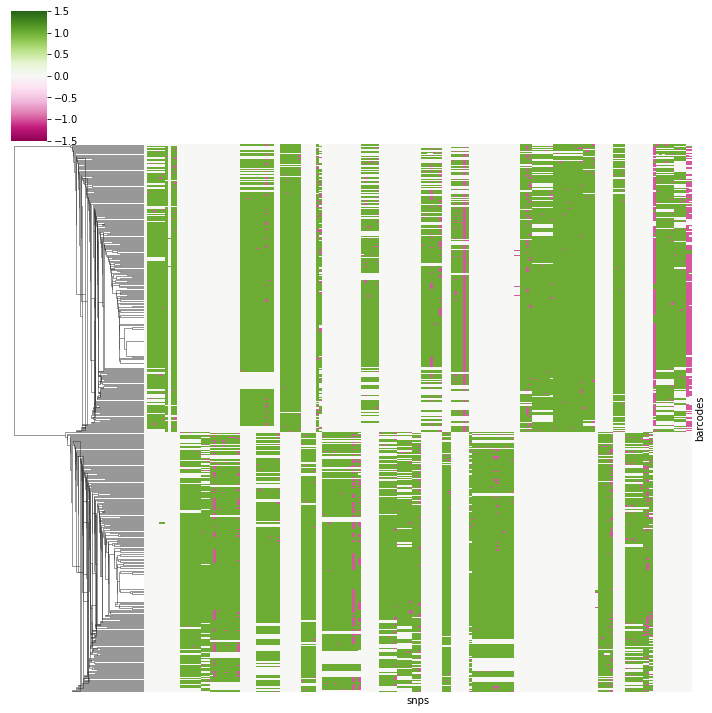

In [660]:
sns.clustermap(snp_gt_filtered.T, cmap='PiYG',yticklabels=False,xticklabels=False, method= 'centroid', 
               vmin=-1.5,
               vmax =1.5,
               col_cluster= False,
              )

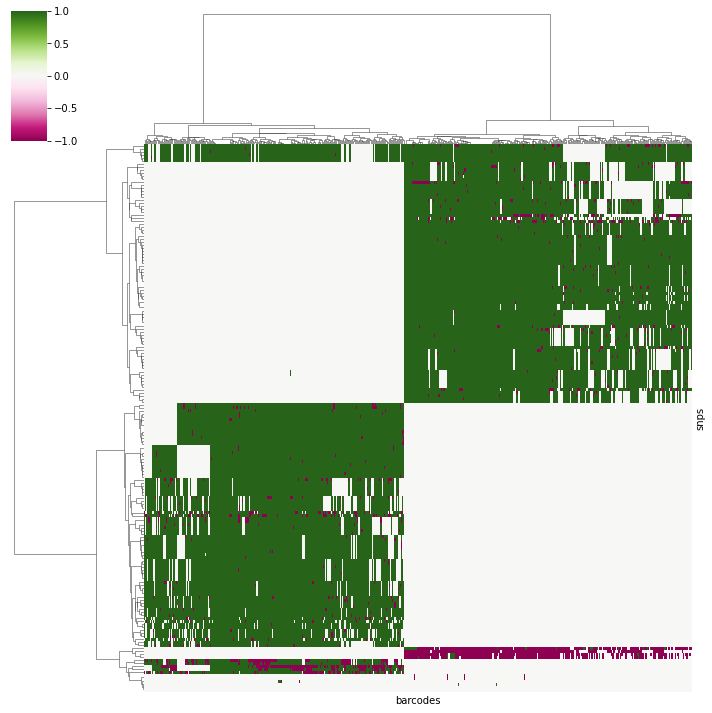

In [610]:
sns.clustermap(snp_gt_filtered, 
               
               yticklabels=False,
               xticklabels=False,  
               #row_cluster= False,
               method='ward',
               vmin=-1,
               vmax=1,
               #vcenter=0,
                cmap='PiYG'
              )

<AxesSubplot:xlabel='snps', ylabel='barcodes'>

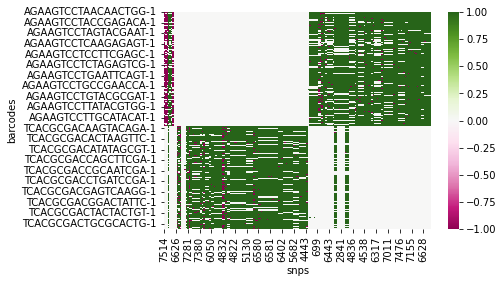

In [605]:
sns.heatmap(snp_gt_filtered.sort_values(snp_gt_filtered.columns.tolist()).T, cmap='PiYG')

In [558]:
snp_gt_filtered

barcodes,AGAAGTCCTAACAACTGG-1,AGAAGTCCTAACTGCGAC-1,AGAAGTCCTAAGACTGGT-1,AGAAGTCCTAAGAGAGAG-1,AGAAGTCCTAAGTTCTCT-1,AGAAGTCCTAATACGTCT-1,AGAAGTCCTAATATCAGC-1,AGAAGTCCTAATATCGCT-1,AGAAGTCCTAATCAGGAG-1,AGAAGTCCTAATGCGTGC-1,...,TCACGCGACTGTGTAGAG-1,TCACGCGACTGTTACTGA-1,TCACGCGACTGTTGTCGA-1,TCACGCGACTTAACGGAG-1,TCACGCGACTTACAGTGT-1,TCACGCGACTTACTAGTC-1,TCACGCGACTTCGCTGAG-1,TCACGCGACTTCTGCCGA-1,TCACGCGACTTCTGGTGC-1,TCACGCGACTTGCCAGAT-1
snps,,,,,,,,,,,,,,,,,,,,,
689,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
692,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
697,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
699,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
700,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7510,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7511,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7513,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [649]:
adata_snp = anndata.AnnData(snp_gt_filtered.T)

/tmp/ipykernel_76948/2007832996.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_snp = anndata.AnnData(snp_gt_filtered.T)
/usr/local/lib/python3.9/dist-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [650]:
adata_snp

AnnData object with n_obs × n_vars = 514 × 182

In [651]:
sc.pp.neighbors(adata_snp, use_rep='X')
sc.tl.leiden(adata_snp, resolution=1)
sc.tl.umap(adata_snp)
sc.tl.pca(adata_snp)

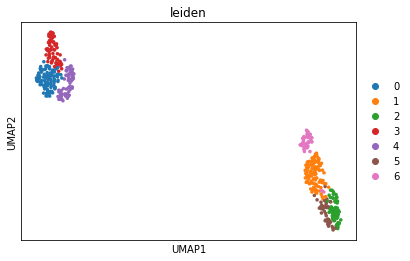

In [652]:
sc.pl.umap(adata_snp, color='leiden',size =50)


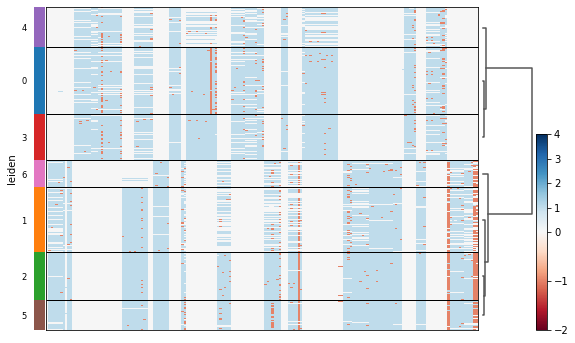

In [653]:
ax = sc.pl.heatmap(adata_snp, 
                   adata_snp.var_names, 
                   groupby='leiden',
                  
                   cmap='RdBu',
                   dendrogram=True, 
                   vmin=-2,
                   vmax=4,
                   vcenter=0
                  )

In [41]:
ls = [0,1,2,3,4,6,7,8,9]
for n in [1,2,3,4] :    
    total =  50 + n
    ls_1 = rm_n(ls,n)
    for n1 in ls_1:
        ls_2 = rm_n(ls_1,n1)
        for n2 in ls_2:
            a = n1*10 + n2
            ls_3 = rm_n(ls_2,n2)
            for n3 in ls_3:
                ls_4 = rm_n(ls_3,n3)
                for n4 in ls_4:
                    ls_5 = rm_n(ls_4,n4)
                    for n5 in ls_5:
                        ls_6 = rm_n(ls_5,n5)
                        for n6 in ls_6:
                            ls_7 = rm_n(ls_6,n6)
                            b = (n3*10+n4)/(n5*10+n6)
                            
                            c = ls_7[0]
                            d = ls_7[-1]
                            
                            if (a +b+c+d == total) & (n5!=0):
                                #print(total)
                                #print(n, n1, n2, n3,n4,n5,n6,c,d )
                                print('{} = {}{} + ({}{})/({}{}) +{}+{}'.format(total,n1, n2, n3,n4,n5,n6,c,d ))
                            

52 = 34 + (90)/(18) +6+7
52 = 36 + (90)/(18) +4+7
52 = 37 + (90)/(18) +4+6
52 = 40 + (76)/(38) +1+9
52 = 41 + (76)/(38) +0+9
52 = 49 + (76)/(38) +0+1
53 = 40 + (78)/(26) +1+9
53 = 41 + (78)/(26) +0+9
53 = 49 + (78)/(26) +0+1


In [45]:
def rm_n(ls, n):
    new_ls = []
    for l in ls:
        if n!=l:
            new_ls.append(l)
    return new_ls

In [44]:
ls = [0,1,2,3,5,4,6,7,8,9]
sum_ls = []
for n in ls :    
    
    ls_1 = rm_n(ls,n)
    for n1 in ls_1:
        ls_2 = rm_n(ls_1,n1)
        for n2 in ls_2:
            
            ls_3 = rm_n(ls_2,n2)
            for n3 in ls_3:
                
                ls_4 = rm_n(ls_3,n3)
                for n4 in ls_4:
                    
                    ls_5 = rm_n(ls_4,n4)
                    
                    for n5 in ls_5:
                        ls_6 = rm_n(ls_5,n5)
                        
                        for n6 in ls_6:
                            
                            ls_7 = rm_n(ls_6,n6)
                            
                            for n7 in ls_7:
                            
                                ls_8 = rm_n(ls_7,n7)
                                for n8 in ls_8:
                                    ls_9 = rm_n(ls_8,n8)
                                    n9=ls_9[0]
                            if (n + n1+n2+n3 == n3+n4+n5+n6) & (n + n1+n2+n3 ==n6+n7+n8+n9+n):
                                #print(total)
                                total = n +n1+n2+n3
                                if total not in sum_ls:
                                                         #print(n, n1, n2, n3,n4,n5,n6,c,d )
                                    print('{}-{}-{}-{}=={}-{}-{}-{}=={}-{}-{}-{}-{}'.format(n,n1, n2, n3,n3,n4,n5,n6,n6,n7,n8,n9,n ))
                                    print('the sum is {}'.format(total))
                                    sum_ls.append(total)

0-2-8-9==9-1-6-3==3-7-4-5-0
the sum is 19
0-3-7-8==8-5-4-1==1-9-6-2-0
the sum is 18
0-3-8-9==9-1-4-6==6-7-5-2-0
the sum is 20
0-3-9-5==5-4-7-1==1-8-6-2-0
the sum is 17
0-5-9-2==2-6-7-1==1-8-4-3-0
the sum is 16
1-5-6-9==9-0-4-8==8-7-3-2-1
the sum is 21
5-0-8-9==9-2-4-7==7-6-3-1-5
the sum is 22
7-1-6-9==9-2-4-8==8-5-3-0-7
the sum is 23


In [46]:
ls = [0,1,2,3,5,4,6,7,8,9]
ordered_ls = []
for n in ls :    
    
    ls_1 = rm_n(ls,n)
    for n1 in ls_1:
        ls_2 = rm_n(ls_1,n1)
        for n2 in ls_2:
            
            ls_3 = rm_n(ls_2,n2)
            for n3 in ls_3:
                
                ls_4 = rm_n(ls_3,n3)
                for n4 in ls_4:
                    
                    ls_5 = rm_n(ls_4,n4)
                    
                    for n5 in ls_5:
                        ls_6 = rm_n(ls_5,n5)
                        
                        for n6 in ls_6:
                            
                            ls_7 = rm_n(ls_6,n6)
                            
                            for n7 in ls_7:
                            
                                ls_8 = rm_n(ls_7,n7)
                                for n8 in ls_8:
                                    ls_9 = rm_n(ls_8,n8)
                                    n9=ls_9[0]
                                    if (n+n1+7+n2 == 22) & (n3+7+n4+4 == 22 ) & (8+n5+n6+n7 == 22)&(n8+9+n9+8 ==22):
                                        if (n+n3+8+n8 ==22)& (n1+7+n5+9==22)& (7+n4+n6+n9==22)&(n2+4+n7+8==22):
                                            print(n, n1,n2, n3, n4, n5, n6, n7, n8, n9)
                                    
                                    
                                    
                                    
                                    
                           

8 0 7 2 9 6 5 3 4 1
8 6 1 4 7 0 5 9 2 3
